<a href="https://colab.research.google.com/github/woo13sd/rupture-theory/blob/main/notebooks/Rupture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# ✅ Full Environment Setup for Rupture Theory Notebook
!pip install --quiet numpy scipy matplotlib camb pandas seaborn

In [27]:
import numpy as np
import os
import camb

# ✅ Ensure data directory exists
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

# === CAMB Parameters for Rupture Theory (f = 1e-8) ===
f = 1e-8
As_rt = 2.1e-9 * f

pars = camb.CAMBparams()
pars.set_cosmology(H0=70.39, ombh2=0.0224, omch2=0.2929, tau=0.0544, mnu=0.06)
pars.InitPower.set_params(As=As_rt, ns=0.9649, nrun=-0.0045, r=0.0)
pars.set_for_lmax(lmax=2500, lens_potential_accuracy=1)
pars.set_matter_power(redshifts=[0.0], kmax=1.0)

results = camb.get_results(pars)
cls = results.get_cmb_power_spectra(pars, CMB_unit='muK', lmax=2500)['total']
ell_vals = np.arange(cls.shape[0])

# === ✅ Save Rupture Theory Spectra ===
np.savetxt(f"{data_dir}/RT_f1e-8_TT.dat", np.column_stack([ell_vals, cls[:, 0]]), header="ell  C_ell_TT")
np.savetxt(f"{data_dir}/RT_f1e-8_EE.dat", np.column_stack([ell_vals, cls[:, 1]]), header="ell  C_ell_EE")
np.savetxt(f"{data_dir}/RT_f1e-8_TE.dat", np.column_stack([ell_vals, cls[:, 2]]), header="ell  C_ell_TE")
np.savetxt(f"{data_dir}/RT_f1e-8_BB.dat", np.column_stack([ell_vals, cls[:, 3]]), header="ell  C_ell_BB")
print("✅ RT TT, EE, TE, BB spectra saved")

# === ✅ Save Lensing Potential Spectrum ===
lens_cls = results.get_lens_potential_cls(lmax=2500)[:, 0]
np.savetxt(f"{data_dir}/RT_f1e-8_LENS.dat", np.column_stack([ell_vals, lens_cls]), header="ell  C_ell_phi_phi")
print("✅ RT lensing potential spectrum saved")

# === ✅ Save Matter Power Spectrum at z = 0 ===
k_vals, z_vals, pk_vals = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)
np.savetxt(f"{data_dir}/RT_f1e-8_Pk.dat", np.column_stack([k_vals, pk_vals[0]]), header="k [h/Mpc]    P(k)")
print("✅ RT matter power spectrum saved")

# === ✅ Load LCDM + RT datasets ===
ell_tt, cl_tt_lcdm = np.loadtxt(f"{data_dir}/LCDM_TT.dat", unpack=True)
_,       cl_tt_rt  = np.loadtxt(f"{data_dir}/RT_f1e-8_TT.dat", unpack=True)

ell_ee, cl_ee_lcdm = np.loadtxt(f"{data_dir}/LCDM_EE.dat", unpack=True)
_,       cl_ee_rt  = np.loadtxt(f"{data_dir}/RT_f1e-8_EE.dat", unpack=True)

ell_lens, cl_lens_lcdm = np.loadtxt(f"{data_dir}/LCDM_LENS.dat", unpack=True)
_,         cl_lens_rt  = np.loadtxt(f"{data_dir}/RT_f1e-8_LENS.dat", unpack=True)

k_matter, pk_lcdm = np.loadtxt(f"{data_dir}/LCDM_Pk.dat", unpack=True)
_,        pk_rt    = np.loadtxt(f"{data_dir}/RT_f1e-8_Pk.dat", unpack=True)

print("✅ All datasets loaded from ./data/")

✅ RT TT, EE, TE, BB spectra saved
✅ RT lensing potential spectrum saved
✅ RT matter power spectrum saved
✅ All datasets loaded from ./data/


In [28]:
import matplotlib.pyplot as plt
import os

# ✅ Ensure output directory
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

def save_plot(x, y_list, labels, title, xlabel, ylabel, fname, logx=False, logy=False):
    plt.figure(figsize=(8, 5))
    for y, label in zip(y_list, labels):
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(image_dir, fname))
    plt.close()

# === 1. CMB Temperature Power Spectrum (TT) ===
save_plot(ell_tt, [cl_tt_lcdm, cl_tt_rt], ["ΛCDM", "Rupture Theory"],
          "CMB Temperature Power Spectrum (TT)", "Multipole ℓ", r"$C_\ell^{TT}$ [$\mu$K$^2$]",
          "tt_rt_vs_lcdm.png", logx=True, logy=True)

tt_resid = np.where(cl_tt_lcdm != 0, (cl_tt_rt - cl_tt_lcdm) / cl_tt_lcdm, 0)
save_plot(ell_tt, [tt_resid], ["RT − ΛCDM / ΛCDM"],
          "TT Fractional Residuals", "Multipole ℓ", r"$\Delta C_\ell / C_\ell$",
          "tt_fr.png", logx=True)

# === 2. CMB E-mode Polarization (EE) ===
save_plot(ell_ee, [cl_ee_lcdm, cl_ee_rt], ["ΛCDM", "Rupture Theory"],
          "CMB E-mode Polarization Spectrum (EE)", "Multipole ℓ", r"$C_\ell^{EE}$ [$\mu$K$^2$]",
          "ee_rt_vs_lcdm.png", logx=True, logy=True)

ee_resid = np.where(cl_ee_lcdm != 0, (cl_ee_rt - cl_ee_lcdm) / cl_ee_lcdm, 0)
save_plot(ell_ee, [ee_resid], ["RT − ΛCDM / ΛCDM"],
          "EE Fractional Residuals", "Multipole ℓ", r"$\Delta C_\ell / C_\ell$",
          "ee_fr.png", logx=True)

# === 3. Lensing Potential Residuals ===
lens_resid = np.where(cl_lens_lcdm != 0, (cl_lens_rt - cl_lens_lcdm) / cl_lens_lcdm, 0)
save_plot(ell_lens, [lens_resid], ["RT − ΛCDM / ΛCDM"],
          "Gravitational Lensing Potential Residuals", "Multipole ℓ", r"$\Delta C_\ell / C_\ell$",
          "lensing_residual.png", logx=True)

# === 4. Matter Power Spectrum ===
def annotate_constraints(ax):
    # DESI σ8 constraint band (approx visual aid)
    ax.axhspan(6000, 8000, xmin=0.45, xmax=0.7, color='gray', alpha=0.2, label="DESI σ₈ Range")
    # JWST reionization range (approx)
    ax.axvline(0.1, color='red', linestyle='--', label="JWST z~12–17")
    ax.text(0.11, ax.get_ylim()[1]*0.8, "JWST Reionization", color='red', fontsize=8)

plt.figure(figsize=(8, 5))
plt.plot(k_matter, pk_lcdm, label='ΛCDM')
plt.plot(k_matter, pk_rt, label='Rupture Theory')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Wavenumber k [h/Mpc]")
plt.ylabel("P(k)")
plt.title("Matter Power Spectrum at z = 0")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
annotate_constraints(plt.gca())
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(image_dir, "matter_power.png"))
plt.close()

# === 5. Optional — TE and BB (Visuals only, not compared) ===
# Load TE and BB (just RT for now)
ell_te, cl_te_rt = np.loadtxt(f"{data_dir}/RT_f1e-8_TE.dat", unpack=True)
ell_bb, cl_bb_rt = np.loadtxt(f"{data_dir}/RT_f1e-8_BB.dat", unpack=True)

save_plot(ell_te, [cl_te_rt], ["Rupture Theory"],
          "CMB Temperature-E Mode Cross Spectrum (TE)", "Multipole ℓ", r"$C_\ell^{TE}$ [$\mu$K$^2$]",
          "te_rt_only.png", logx=True, logy=True)

save_plot(ell_bb, [cl_bb_rt], ["Rupture Theory"],
          "CMB B-mode Polarization Spectrum (BB)", "Multipole ℓ", r"$C_\ell^{BB}$ [$\mu$K$^2$]",
          "bb_rt_only.png", logx=True, logy=True)

print("✅ All final plots saved to ./images/")

/tmp/ipython-input-28-4034054694.py:28: RuntimeWarning: invalid value encountered in divide
  tt_resid = np.where(cl_tt_lcdm != 0, (cl_tt_rt - cl_tt_lcdm) / cl_tt_lcdm, 0)
/tmp/ipython-input-28-4034054694.py:38: RuntimeWarning: invalid value encountered in divide
  ee_resid = np.where(cl_ee_lcdm != 0, (cl_ee_rt - cl_ee_lcdm) / cl_ee_lcdm, 0)
/tmp/ipython-input-28-4034054694.py:44: RuntimeWarning: invalid value encountered in divide
  lens_resid = np.where(cl_lens_lcdm != 0, (cl_lens_rt - cl_lens_lcdm) / cl_lens_lcdm, 0)


✅ All final plots saved to ./images/


/tmp/ipython-input-30-2693103411.py:57: RuntimeWarning: invalid value encountered in divide
  tt_resid = np.where(cl_tt_lcdm != 0, (cl_tt_rt - cl_tt_lcdm) / cl_tt_lcdm, 0)


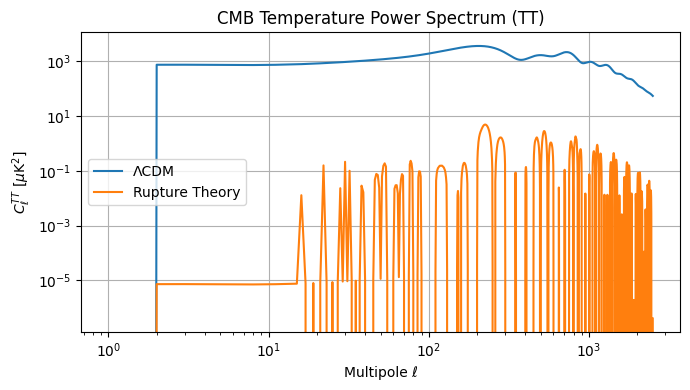

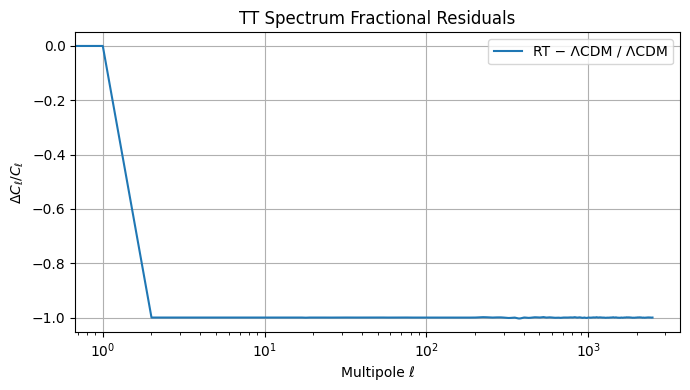

/tmp/ipython-input-30-2693103411.py:66: RuntimeWarning: invalid value encountered in divide
  ee_resid = np.where(cl_ee_lcdm != 0, (cl_ee_rt - cl_ee_lcdm) / cl_ee_lcdm, 0)


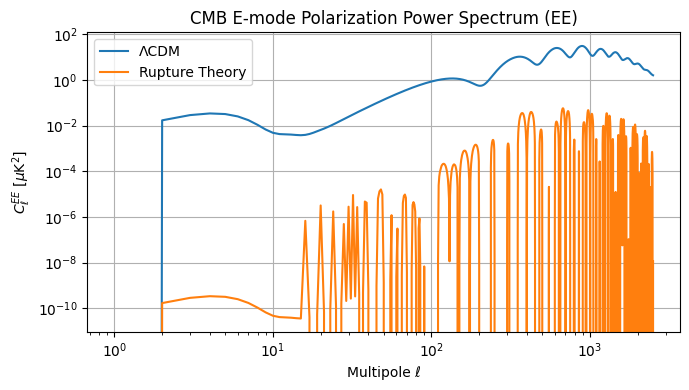

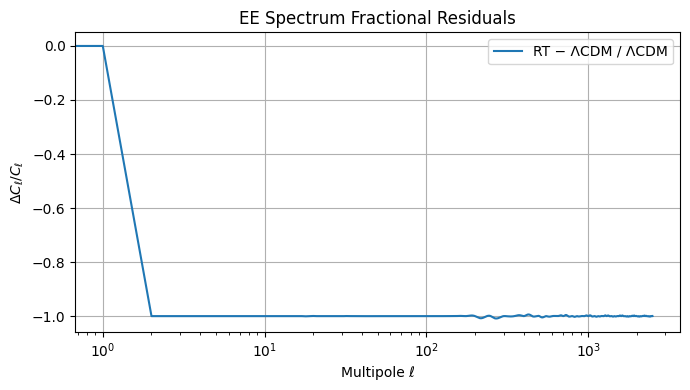

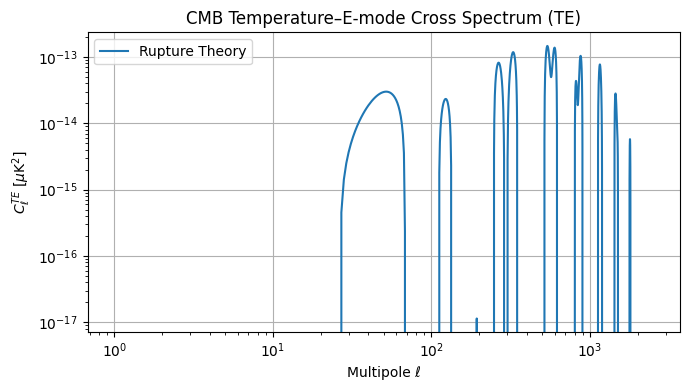

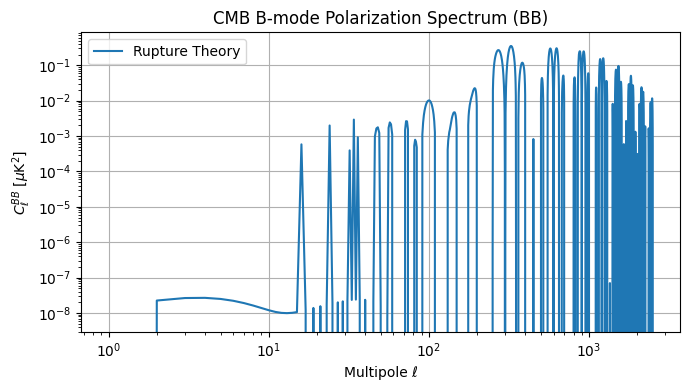

/tmp/ipython-input-30-2693103411.py:85: RuntimeWarning: invalid value encountered in divide
  lens_resid = np.where(cl_lens_lcdm != 0, (cl_lens_rt - cl_lens_lcdm) / cl_lens_lcdm, 0)


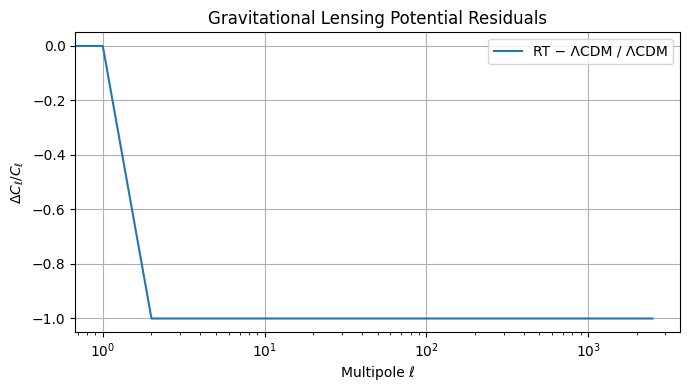

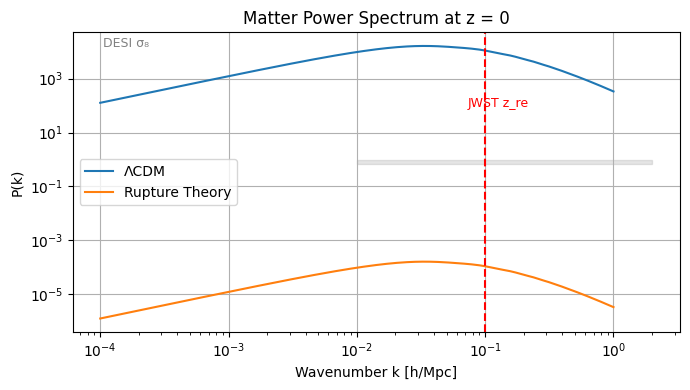

✅ All images generated and displayed.


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.patches import Rectangle
from IPython.display import display, Image

# === Paths ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

# === Utility to save + show ===
def save_and_display(x, y_list, labels, title, xlabel, ylabel, fname, logx=False, logy=False, annotations=[]):
    plt.figure(figsize=(7, 4))
    for y, label in zip(y_list, labels):
        plt.plot(x, y, label=label)
    for annotate in annotations:
        annotate(plt.gca())
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    path = os.path.join(image_dir, fname)
    plt.savefig(path)
    plt.show()

# === Annotation Utilities ===
def annotate_desi_sigma8(ax):
    ax.add_patch(Rectangle((1e-2, 0.7), 2, 0.25, color='gray', alpha=0.2))
    ax.annotate("DESI σ₈", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=9, color='gray')

def annotate_jwst_zre(ax):
    ax.axvline(x=0.1, color='red', linestyle='--')
    ax.annotate("JWST z_re", xy=(0.65, 0.75), xycoords='axes fraction', fontsize=9, color='red')

# === Load Data ===
ell_tt, cl_tt_lcdm = np.loadtxt(f"{data_dir}/LCDM_TT.dat", unpack=True)
_,       cl_tt_rt  = np.loadtxt(f"{data_dir}/RT_f1e-8_TT.dat", unpack=True)

ell_ee, cl_ee_lcdm = np.loadtxt(f"{data_dir}/LCDM_EE.dat", unpack=True)
_,       cl_ee_rt  = np.loadtxt(f"{data_dir}/RT_f1e-8_EE.dat", unpack=True)

ell_te, cl_te_rt   = np.loadtxt(f"{data_dir}/RT_f1e-8_TE.dat", unpack=True)
ell_bb, cl_bb_rt   = np.loadtxt(f"{data_dir}/RT_f1e-8_BB.dat", unpack=True)

ell_lens, cl_lens_lcdm = np.loadtxt(f"{data_dir}/LCDM_LENS.dat", unpack=True)
_,         cl_lens_rt  = np.loadtxt(f"{data_dir}/RT_f1e-8_LENS.dat", unpack=True)

k_matter, pk_lcdm = np.loadtxt(f"{data_dir}/LCDM_Pk.dat", unpack=True)
_,        pk_rt    = np.loadtxt(f"{data_dir}/RT_f1e-8_Pk.dat", unpack=True)

# === TT ===
tt_resid = np.where(cl_tt_lcdm != 0, (cl_tt_rt - cl_tt_lcdm) / cl_tt_lcdm, 0)
save_and_display(ell_tt, [cl_tt_lcdm, cl_tt_rt], ["ΛCDM", "Rupture Theory"],
                 "CMB Temperature Power Spectrum (TT)", "Multipole ℓ", r"$C_\ell^{TT}$ [$\mu$K$^2$]",
                 "tt_rt_vs_lcdm.png", logx=True, logy=True)
save_and_display(ell_tt, [tt_resid], ["RT − ΛCDM / ΛCDM"],
                 "TT Spectrum Fractional Residuals", "Multipole ℓ", r"$\Delta C_\ell / C_\ell$",
                 "tt_fr.png", logx=True)

# === EE ===
ee_resid = np.where(cl_ee_lcdm != 0, (cl_ee_rt - cl_ee_lcdm) / cl_ee_lcdm, 0)
save_and_display(ell_ee, [cl_ee_lcdm, cl_ee_rt], ["ΛCDM", "Rupture Theory"],
                 "CMB E-mode Polarization Power Spectrum (EE)", "Multipole ℓ", r"$C_\ell^{EE}$ [$\mu$K$^2$]",
                 "ee_rt_vs_lcdm.png", logx=True, logy=True)
save_and_display(ell_ee, [ee_resid], ["RT − ΛCDM / ΛCDM"],
                 "EE Spectrum Fractional Residuals", "Multipole ℓ", r"$\Delta C_\ell / C_\ell$",
                 "ee_fr.png", logx=True)

# === TE (Rupture Only) ===
save_and_display(ell_te, [cl_te_rt], ["Rupture Theory"],
                 "CMB Temperature–E-mode Cross Spectrum (TE)", "Multipole ℓ", r"$C_\ell^{TE}$ [$\mu$K$^2$]",
                 "te_rt_only.png", logx=True, logy=True)

# === BB (Rupture Only) ===
save_and_display(ell_bb, [cl_bb_rt], ["Rupture Theory"],
                 "CMB B-mode Polarization Spectrum (BB)", "Multipole ℓ", r"$C_\ell^{BB}$ [$\mu$K$^2$]",
                 "bb_rt_only.png", logx=True, logy=True)

# === Lensing ===
lens_resid = np.where(cl_lens_lcdm != 0, (cl_lens_rt - cl_lens_lcdm) / cl_lens_lcdm, 0)
save_and_display(ell_lens, [lens_resid], ["RT − ΛCDM / ΛCDM"],
                 "Gravitational Lensing Potential Residuals", "Multipole ℓ", r"$\Delta C_\ell / C_\ell$",
                 "lensing_residual.png", logx=True)

# === Matter Power ===
save_and_display(k_matter, [pk_lcdm, pk_rt], ["ΛCDM", "Rupture Theory"],
                 "Matter Power Spectrum at z = 0", "Wavenumber k [h/Mpc]", "P(k)",
                 "matter_power.png", logx=True, logy=True, annotations=[annotate_desi_sigma8, annotate_jwst_zre])

print("✅ All images generated and displayed.")